# signedfac

Let $X$ denote an $N\times M$ matrix.  Optionally, let $C,D$ give covariate information about each row and/or each column.  Let $k\in \mathbb{N}$.

`signedfac` is a package for obtaining low-dimensional summaries of the rows and columns of the matrix $X$.  It achieves this by fitting a model family $p(x;B_U,B_V,\mu_U,\Sigma_U,\mu_V,\sigma_V,\theta)$ to the observed matrix $X$.  This model family is defined by the following generative story:

$$U_i \sim \mathcal{N}(\mu_U + B_U C_i,\Sigma_U)\qquad U_i \in \mathbb{R}^k, i\in \{0\cdots N-1\}$$
$$V_j \sim \mathcal{N}(\mu_V + B_V D_j,\Sigma_V)\qquad V_j \in \mathbb{R}^k, j\in \{0\cdots N-1\}$$
$$X_{ij}|U,V \sim \mathrm{datamodel}(\cdot ; U_i^\top V_j, \theta_j)$$


At the moment, $\mathrm{datamodel}$ can be one of the following:

1. `normal` -- $p(x;w,\theta) = \mathcal{N}(x; w,\theta)$
2. `negativebinomial` -- $p(x;w,\theta) = \mathrm{NegativeBinomial}(x;\ \mathrm{logit}(w),\theta)$
3. `bernoulli` -- $p(x;w) = \mathrm{Bernoulli}(x;\ \mathrm{logit}(w))$

Once this model is fit, the `signedfac` package estimates the posterior means, $\mathbb{E}[U,V|X]$. These low-dimensional posterior means can be understood as summaries of each row and each column.  These representations can be used for visualization or downstream analysis.


In [61]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pylab as plt
import numpy.random as npr
import signedfac
import scipy as sp
import scipy.special

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# example usage
First we'll make some simulated data.  Note we will not simulate directly from the true prior -- in practice the prior is basically never right.  It is, however, essential to have this prior to avoid overfitting in data-starved situations.  Even though we're not sampling from the prior, we'll be able to use `signedfac` to detect the overall structure of what's going on in the data.

In [54]:
# we'll design it so that there are two different kinds of rows.  the first 25 will be one way
# the second 25 will be another way
U=npr.randn(50,2); U[:25]+=8

# we'll do the same for columns.  the first 10 will be one way, the second 10 another
V=npr.randn(80,2); V[:10]+=8

# make data
X=npr.randn(50,80)+U@V.T

In [55]:
# initialize model, using the "normal" datamodel -- this is just a standard factor analysis model.  
# if your data is really normal and you don't have covariates
# and you don't want to use GPU-accleration, you could use 
# sklearn.linear_decomposition.FactorAnalysis for this instead
model=signedfac.initialize(X,2,'normal')

# send data to tensorflow (& to the GPU if you have one)
X_tf = signedfac.to_tensorflow(X)

# initialize trainer.  this object fits the model
trainer=signedfac.Trainer(X_tf,model)

In [56]:
# train the model, using 10 iterations
trainer.train_tqdm_notebook(maxiter=10)

  0%|          | 0/10 [00:00<?, ?it/s]

Not currently training.


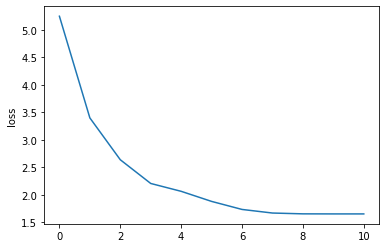

In [57]:
# look at losses over time
trainer.status()

In [58]:
# get low-dimensional summaries
row_loadings=model.row_loadings
col_loadings=model.col_loadings

Text(0.5, 1.0, 'same with columns')

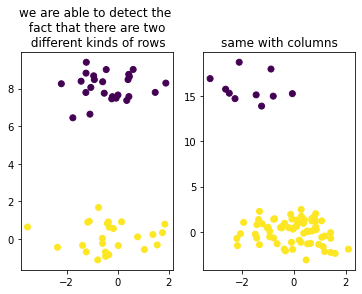

In [59]:
plt.subplot(1,2,1)
plt.scatter(row_loadings[:,0],row_loadings[:,1],c=np.r_[0:len(row_loadings)]>=25)
plt.title("we are able to detect the \n fact that there are two \n different kinds of rows")

plt.subplot(1,2,2)
plt.scatter(col_loadings[:,0],col_loadings[:,1],c=np.r_[0:len(col_loadings)]>=10)
plt.title("same with columns")

# negative binomial example

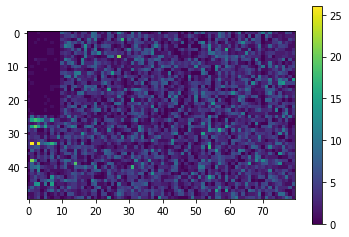

In [161]:
U=npr.randn(50,2)*.1; U[:25]+=.5
V=npr.randn(80,2)*.1; V[:10]+=3.5
thetas=npr.rand(80)*3+2

X=npr.negative_binomial(thetas[None,:],sp.special.expit(U@V.T))

plt.imshow(X)
plt.colorbar()

  0%|          | 0/500 [00:00<?, ?it/s]

Not currently training.


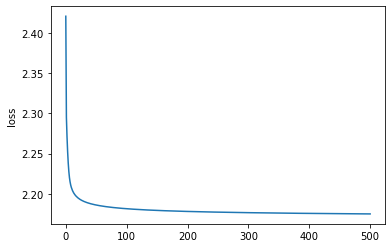

In [171]:
model=signedfac.initialize(X,2,'negativebinomial',diagsig=True)
X_tf = signedfac.to_tensorflow(X)
trainer=signedfac.Trainer(X_tf,model)
trainer.train_tqdm_notebook(maxiter=500)
trainer.status()

Text(0, 0.5, 'estimate')

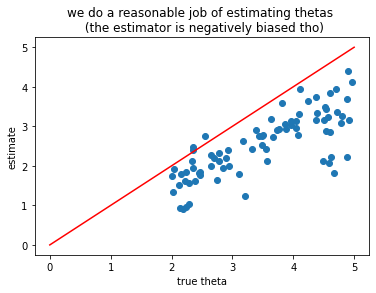

In [172]:
plt.title("we do a reasonable job of estimating thetas \n (the estimator is negatively biased tho)")
plt.scatter(thetas,model.thetas.numpy())
plt.plot([0,5],[0,5],'r-')
plt.xlabel("true theta")
plt.ylabel('estimate')

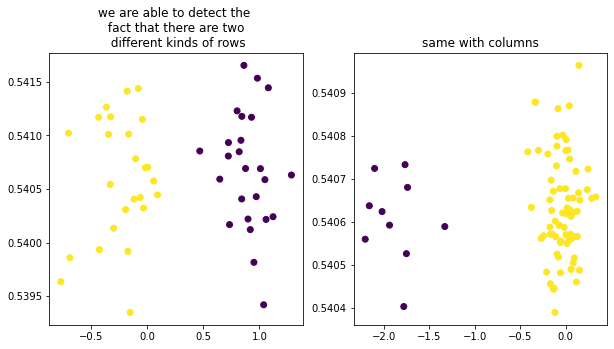

In [174]:

row_loadings=model.row_loadings
col_loadings=model.col_loadings

plt.gcf().set_size_inches(10,5)
plt.subplot(1,2,1)
plt.scatter(row_loadings[:,0],row_loadings[:,1],c=np.r_[0:len(row_loadings)]>=25)
plt.title("we are able to detect the \n fact that there are two \n different kinds of rows")

plt.subplot(1,2,2)
plt.scatter(col_loadings[:,0],col_loadings[:,1],c=np.r_[0:len(col_loadings)]>=10)
plt.title("same with columns");

# a dastardly case

What if some columns are identically zero?  We don't want the algorithm to utterly fail...

In [227]:
U=npr.randn(50,2); U[:25]+=8
V=npr.randn(80,2); V[:10]+=8
X=npr.randn(50,80)+U@V.T
X[:,25:30]=0
Xnb=npr.poisson(np.exp(X/30))
Xnb[:,25:30]=0

  0%|          | 0/10 [00:00<?, ?it/s]

Not currently training.


1e-08

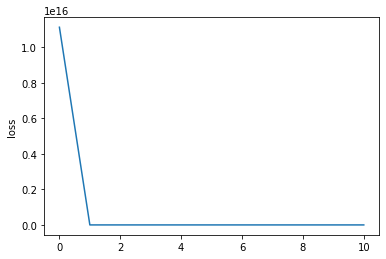

In [245]:
model=signedfac.initialize(X,2,'normal')
X_tf = signedfac.to_tensorflow(X)
trainer=signedfac.Trainer(X_tf,model)
trainer.train_tqdm_notebook(maxiter=10)
trainer.status()
model.thetas.numpy().min()

  0%|          | 0/300 [00:00<?, ?it/s]

Not currently training.


0.006404323930543772

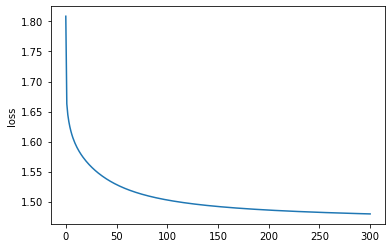

In [244]:
model=signedfac.initialize(Xnb,2,'negativebinomial')
X_tf = signedfac.to_tensorflow(Xnb)
trainer=signedfac.Trainer(X_tf,model)
trainer.train_tqdm_notebook(maxiter=300)
trainer.status()
model.thetas.numpy().min()

In [238]:
zfoo2=model._get_zeta(X_tf).numpy()

In [240]:
zfoo

array([  359.3447379 ,   376.33981574,   355.36048936,   376.05061318,
         344.73823282,   366.83517765,   352.46951812,   379.22854683,
         382.14197121,   372.6852872 ,    77.7377341 ,   112.40525368,
          95.99295714,    46.30269009,    99.00982619,    67.11507303,
          68.08962667,    84.91634462,    65.77337741,   100.30496907,
          85.34447006,    94.25194246,    74.35257619,   133.95597398,
          89.9897052 , -5517.03658548, -5517.03658548, -5517.03658548,
       -5517.03658548, -5517.03658548,    21.22191218,    49.07121754,
          75.91877052,   140.31742483,    75.12609009,    93.46881636,
          66.14163059,    93.74504266,    51.75458921,    66.04662533,
         118.35655579,   101.33639095,    76.64968473,    50.56954839,
         106.10152662,    61.20527998,    41.61970841,    90.27036367,
          81.85018274,    83.1480197 ,    96.99135066,    34.81522932,
         132.05364384,    72.88828101,    92.58403041,    79.99914385,
      

In [243]:
zfoo2[25],zfoo[25]

(-7857.250538466939, -5517.036585482654)

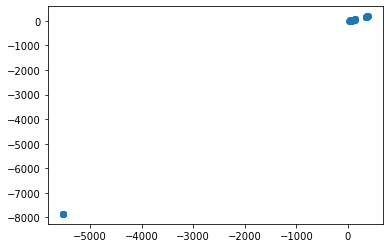

In [239]:
plt.scatter(zfoo,zfoo2)